### FT Data

In [25]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output, get_ingrs
from PIL import Image, ImageFile
import time
import pandas as pd

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'fittime_ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'fittime_instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [13]:
dataset = pickle.load(open(os.path.join(data_dir, 'train_dataset.pkl'), 'rb'))

In [14]:
dataset

[{'id': '44565_20190128_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['大米', '南瓜', '菠菜', '鸭（鸭肉）'],
  'images': ['20190128/hotcamp_44565_20190128_LUNCH.jpg'],
  'title': []},
 {'id': '58735_20190220_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['西兰花', '番茄', '鸡蛋', '猪肉(瘦)'],
  'images': ['20190220/hotcamp_58735_20190220_LUNCH.jpg'],
  'title': []},
 {'id': '63070_20190415_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['玉米', '樱桃番茄（圣女果）', '黄瓜', '鸡蛋', '牛奶'],
  'images': ['20190415/hotcamp_63070_20190415_BREAKFAST.jpg'],
  'title': []},
 {'id': '63070_20190417_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['全麦面包', '黄瓜', '牛奶', '坚果'],
  'images': ['20190417/hotcamp_63070_20190417_BREAKFAST.jpg'],
  'title': []},
 {'id': '63070_20190417_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['蔬菜', '土豆', '红薯', '玉米', '鹌鹑蛋'],
  'images': ['20190417/hotcamp_63070_20190417_LUNCH.jpg'],
  'title': []},


In [33]:
transf_list = []
transf_list.append(transforms.Resize(256))
transf_list.append(transforms.CenterCrop(224))
transform = transforms.Compose(transf_list)


73022_20190411_LUNCH
['猪肉(瘦)', '茄子', '卷心菜', '青菜', '黄豆芽']


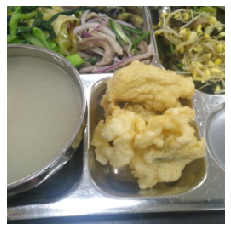

-----------------------------------------
73022_20190412_BREAKFAST
['鸡蛋', '青菜', '酸辣土豆丝（按拳）', '豆浆(无糖)', '牛奶']


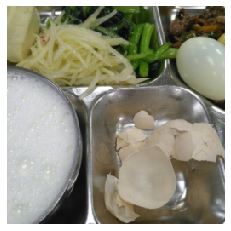

-----------------------------------------
73022_20190412_DINNER
['鱼肉', '鸡肉', '豆腐干']


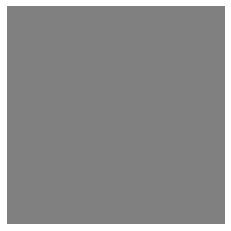

-----------------------------------------
73022_20190412_LUNCH
['米饭', '香蕉', '橙', '冬瓜', '青菜']


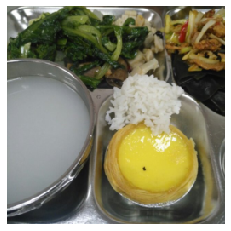

-----------------------------------------
73022_20190413_BREAKFAST
['鸡蛋', '西红柿炒鸡蛋(番茄炒蛋)（按拳）', '青菜', '牛奶', '白粥']


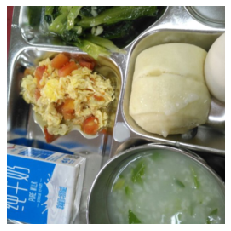

-----------------------------------------
73022_20190413_DINNER
['西兰花', '番茄', '杂粮粥', '南瓜']


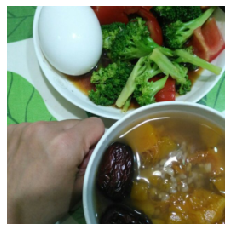

-----------------------------------------
73022_20190413_LUNCH
['鸡肉', '藕', '茄子', '青菜', '豆角']


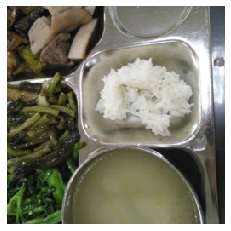

-----------------------------------------
73022_20190414_BREAKFAST
['番茄', '西兰花', '杂粮粥', '南瓜']


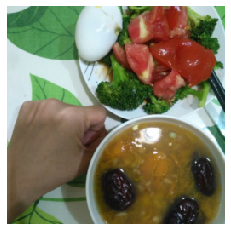

-----------------------------------------
73022_20190414_DINNER
['杂粮粥', '鸡蛋', '西兰花']


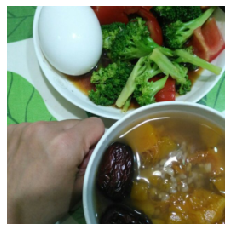

-----------------------------------------
73022_20190414_LUNCH
['鱼肉', '豆腐']


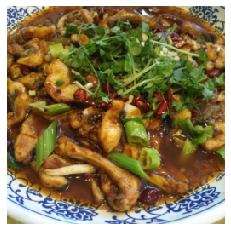

-----------------------------------------
73022_20190415_BREAKFAST
['纯牛奶', '鸡蛋(煮)', '大白菜', '香菇(鲜)']


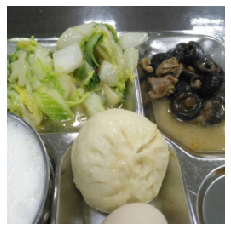

-----------------------------------------
73022_20190415_DINNER
['豆腐', '鱼肉']


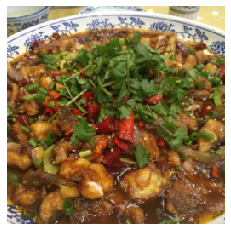

-----------------------------------------
73022_20190415_LUNCH
['鸡肉', '猪肉(瘦)', '米饭', '卷心菜', '油麦菜']


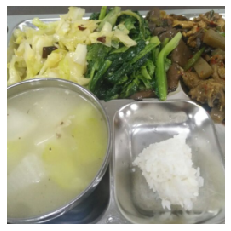

-----------------------------------------
73022_20190416_BREAKFAST
['鸡蛋', '牛奶', '青菜', '黄豆芽', '牛肉(瘦)']


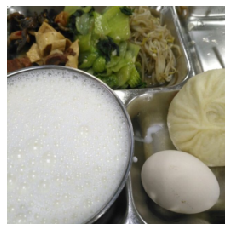

-----------------------------------------
73022_20190416_DINNER
['杂粮饭', '青菜']


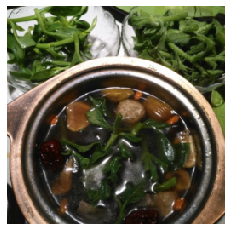

-----------------------------------------
73022_20190417_BREAKFAST
['菠菜', '鸡蛋', '牛奶', '胡萝卜（煮）（按拳）', '豌豆(鲜)']


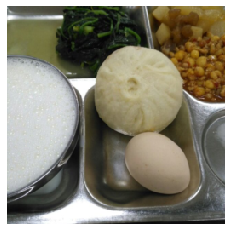

-----------------------------------------
73022_20190418_BREAKFAST
['牛奶', '西红柿炒鸡蛋(番茄炒蛋)（按拳）', '油麦菜', '绿豆芽', '鸡蛋']


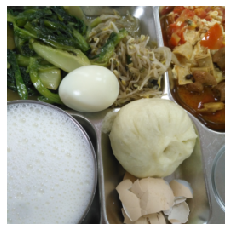

-----------------------------------------
73022_20190418_DINNER
['菠菜', '花菜', '豆角', '鸡肉', '藕']


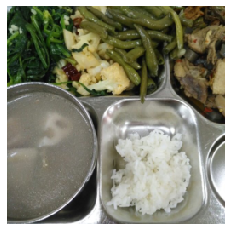

-----------------------------------------
73022_20190419_BREAKFAST
['牛奶', '鸡蛋', '土豆', '青菜']


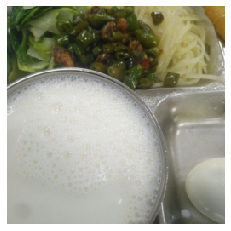

-----------------------------------------


In [45]:
image_dir = "/media/eganlau/meal_pictures/Images/"
ImageFile.LOAD_TRUNCATED_IMAGES = True

for data in dataset[31:50]:
    print(data["id"])
    print(data["ingredients"])
    image_transf = transform(Image.open(image_dir + data['images'][0]).convert('RGB'))
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    print("-----------------------------------------")


In [6]:
print (instrs_vocab_size, ingr_vocab_size)

180 180


In [7]:
ingr_df = pd.DataFrame(ingrs_vocab)
ingr_df.head()

,0
0,<end>
1,鸡蛋
2,米饭
3,纯牛奶
4,番茄


In [48]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=True
args.embed_size=80
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join("../saved_models/inversecooking/model/checkpoints", 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = True
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


loaded model
Elapsed time: 0.6414515972137451


In [49]:
        transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [50]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [51]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs/fittime')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

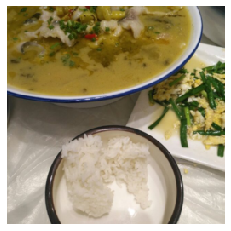

[ 95 175 142 144 146  36]
['杂粮', '基围虾', '窝窝头', '莴笋叶', '青辣椒', '无糖酸奶']
[ 95 175 142 144 146  36]
['杂粮', '基围虾', '窝窝头', '莴笋叶', '青辣椒', '无糖酸奶']
[ 95 175 142 144 146  36]
['杂粮', '基围虾', '窝窝头', '莴笋叶', '青辣椒', '无糖酸奶']
[ 95 175 142 144 146  36]
['杂粮', '基围虾', '窝窝头', '莴笋叶', '青辣椒', '无糖酸奶']


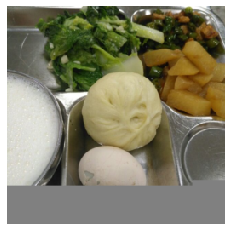

[ 95 175 142 135  99  36]
['杂粮', '基围虾', '窝窝头', '蒸南瓜', '豆腐皮', '无糖酸奶']
[ 95 175 142 135  99  36]
['杂粮', '基围虾', '窝窝头', '蒸南瓜', '豆腐皮', '无糖酸奶']
[ 95 175 142 135  99  36]
['杂粮', '基围虾', '窝窝头', '蒸南瓜', '豆腐皮', '无糖酸奶']
[ 95 175 142 135  99  36]
['杂粮', '基围虾', '窝窝头', '蒸南瓜', '豆腐皮', '无糖酸奶']


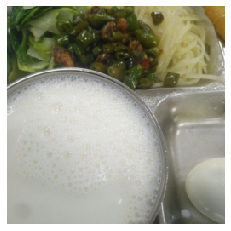

[ 95 175  29  68 135  99]
['杂粮', '基围虾', '紫薯', '花生仁(油炸)', '蒸南瓜', '豆腐皮']
[ 95 175  29  68 135  99]
['杂粮', '基围虾', '紫薯', '花生仁(油炸)', '蒸南瓜', '豆腐皮']
[ 95 175  29  68 135  99]
['杂粮', '基围虾', '紫薯', '花生仁(油炸)', '蒸南瓜', '豆腐皮']
[ 95 175  29  68 135  99]
['杂粮', '基围虾', '紫薯', '花生仁(油炸)', '蒸南瓜', '豆腐皮']


In [52]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(256))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        print(ingr_ids[0])
        print(get_ingrs(ingr_ids[0], ingrs_vocab))
#         recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
#         outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
#         if valid['is_valid'] or show_anyways:
            
#             print ('RECIPE', num_valid)
#             num_valid+=1
#             #print ("greedy:", greedy[i], "beam:", beam[i])
    
#             BOLD = '\033[1m'
#             END = '\033[0m'
#             print (BOLD + '\nTitle:' + END,outs['title'])

#             print (BOLD + '\nIngredients:'+ END)
#             print (', '.join(outs['ingrs']))

#             print (BOLD + '\nInstructions:'+END)
#             print ('-'+'\n-'.join(outs['recipe']))

#             print ('='*20)

#         else:
#             pass
#             print ("Not a valid recipe!")
#             print ("Reason: ", valid['reason'])
        